In [163]:
import pandas as pd
import numpy as np
from transformers import BertTokenizer, BertModel
import torch

In [164]:
data = pd.read_csv('/Users/deansmith/Desktop/AI Class/Final Project/Scraping Data - Sheet1.csv')

data

,Tweet Text,Tweet User
0,Draymond Green enjoying LeBron's Hennessy 😂🍷,TheNBACentel
1,"""Sports gambling isn't available in my state.""...",TheNBACentel
2,Doc Rivers have informed the Bucks he’ll start...,TheNBACentel
3,LeBron with high praise for Gradey Dick: “Dick...,TheNBACentel
4,Paul Pierce was reportedly disguised as a Detr...,TheNBACentel
...,...,...
495,Odds for the next player to appear at a WWE ev...,TheDunkCentral
496,Willie Cauley-Stein plans to sign with the Nan...,TheDunkCentral
497,Real Madrid is showing interest in Lonnie Walk...,TheDunkCentral
498,Amazing year for the WNBA 🔥\n\nExcited to see ...,TheDunkCentral


In [165]:
def binary(category):
    if category == "TheDunkCentral":
        return 1
    else:
        return 0
    
data["Tweet User"] = data["Tweet User"].apply(binary)

data

,Tweet Text,Tweet User
0,Draymond Green enjoying LeBron's Hennessy 😂🍷,0
1,"""Sports gambling isn't available in my state.""...",0
2,Doc Rivers have informed the Bucks he’ll start...,0
3,LeBron with high praise for Gradey Dick: “Dick...,0
4,Paul Pierce was reportedly disguised as a Detr...,0
...,...,...
495,Odds for the next player to appear at a WWE ev...,1
496,Willie Cauley-Stein plans to sign with the Nan...,1
497,Real Madrid is showing interest in Lonnie Walk...,1
498,Amazing year for the WNBA 🔥\n\nExcited to see ...,1


In [166]:
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')

def tokenize(text):
    return tokenizer(text, padding='max_length', truncation=True, max_length=512, return_tensors='pt')

tokenized_data = data.copy()

tokenized_data["Tweet Text"] = tokenized_data["Tweet Text"].apply(tokenize)

tokenized_data

,Tweet Text,Tweet User
0,"[input_ids, token_type_ids, attention_mask]",0
1,"[input_ids, token_type_ids, attention_mask]",0
2,"[input_ids, token_type_ids, attention_mask]",0
3,"[input_ids, token_type_ids, attention_mask]",0
4,"[input_ids, token_type_ids, attention_mask]",0
...,...,...
495,"[input_ids, token_type_ids, attention_mask]",1
496,"[input_ids, token_type_ids, attention_mask]",1
497,"[input_ids, token_type_ids, attention_mask]",1
498,"[input_ids, token_type_ids, attention_mask]",1


In [167]:
model = BertModel.from_pretrained('bert-base-uncased')

def vectorize(tokens):
    with torch.no_grad():
        return model(**tokens).last_hidden_state[:,0,:].numpy()
    
vectorized_data = tokenized_data

vectorized_data["Tweet Text"] = vectorized_data["Tweet Text"].apply(vectorize)

vectorized_data

,Tweet Text,Tweet User
0,"[[-0.16681223, 0.28069177, -0.3418928, -0.0438...",0
1,"[[0.033548195, -0.06567082, 0.5306335, 0.12611...",0
2,"[[0.1477394, 0.021486737, 0.082710356, -0.0671...",0
3,"[[-0.19456813, -0.4588848, 0.017049937, -0.207...",0
4,"[[-0.32451636, -0.29269165, -0.51750773, -0.16...",0
...,...,...
495,"[[-0.9421976, -0.36846521, 0.07396136, 0.15776...",1
496,"[[-0.01138958, -0.14343831, -0.05923294, -0.15...",1
497,"[[-0.45919257, -0.55484647, -0.29068628, -0.14...",1
498,"[[-0.32919732, -0.05579721, -0.35735786, -0.62...",1


In [168]:
vectorized_data["Tweet Text"][0].shape

(1, 768)

In [170]:
import heapq

def cosineSimilarity(v1, v2):
    return np.dot(v1, v2)/(np.linalg.norm(v1)*np.linalg.norm(v2))

def knn(k, X_train, X_test, y_train, y_test):
    similarity_matrix = np.zeros((len(X_test), len(X_train)))

    for i, test_vector in enumerate(X_test):
        for j, train_vector in enumerate(X_train):
            similarity_matrix[i][j] = cosineSimilarity(test_vector[0], train_vector[0])


    predictions = []

    for l in range(len(X_test)):
        nearest_neighbors = heapq.nlargest(k, range(len(similarity_matrix[l])), key=lambda i: similarity_matrix[l][i])

        avg_response = sum(y_train[nearest_neighbors]) / k

        pred = 1

        if avg_response < 0.5:
            pred = 0

        predictions.append(pred)


    score_arr = []

    counter = 0
    for t, val in enumerate(y_test):
        pred = predictions[counter]
        
        if pred == val:
            score_arr.append(1)
        else:
            score_arr.append(0)

        counter += 1



    return sum(score_arr) / len(score_arr)


def kCrossValidation(X, y, k_folds, k_neighbors):
    n = len(X)

    np.random.seed(1)

    indices = np.random.permutation(n)

    X = X[indices]
    y = y[indices]

    X_folds = np.array_split(X, k_folds)
    y_folds = np.array_split(y, k_folds)

    scores = []

    for i in range(k_folds):
        X_train = np.concatenate(X_folds[:i] + X_folds[i+1:])
        y_train = np.concatenate(y_folds[:i] + y_folds[i+1:])

        X_test = X_folds[i]
        y_test = y_folds[i]

        # Compute the cosine similarity matrix

        scores.append(knn(k_neighbors, X_train, X_test, y_train, y_test))


        return sum(scores) / len(scores)
    
#kCrossValidation(vectorized_data["Tweet Text"], vectorized_data["Tweet User"], 5, 10)     

In [171]:
from sklearn.model_selection import train_test_split
import warnings
warnings.filterwarnings("ignore")


train, test = train_test_split(vectorized_data, test_size=0.2, random_state=1)

train = train.reset_index(drop=True)
#test = test.reset_index(drop=True)

test_indices = []

for i, v in enumerate(test["Tweet Text"]):
    test_indices.append(i)

print("K-fold cross validation performance on training data for given values of k (using 4 folds):")

for k in range(2, 11):
    print(str(k) + ": " + str(kCrossValidation(train["Tweet Text"], train["Tweet User"], 4, k)))


K-fold cross validation performance on training data for given values of k (using 4 folds):
2: 0.79
3: 0.83
4: 0.86
5: 0.82
6: 0.82
7: 0.8
8: 0.83
9: 0.81
10: 0.83


In [172]:
k = 4

# get inidices to look back at results from testing data



# Predict for testing data

    # make cosine sim matrix with testing data and training data

# cosine_sim_matrix = np.zeros((len(test), len(train)))

# for i, test_vector in enumerate(test["Tweet Text"]):
#     for j, train_vector in enumerate(train["Tweet Text"]):
#         cosine_sim_matrix[i][j] = cosineSimilarity(test[0], train[0])


knn(k, X_train=train["Tweet Text"], y_train=train["Tweet User"], X_test = test["Tweet Text"], y_test = test["Tweet User"])


    # make predictions


# Load in Bert Model

    # Train on training data

    # Predict on testing data


# Make DSPy model

    # Predict with DSPy model


# Compare/Graph results

0.87

In [173]:
import openai
import dspy
from dspy.teleprompt import BootstrapFewShot

open_ai_key = "API KEY" # removed for GitHub security reasons

openai.api_key = open_ai_key
turbo = dspy.OpenAI(model='gpt-3.5-turbo-instruct', max_tokens=250)
dspy.settings.configure(lm=turbo, temperature=0.5)

In [174]:
class GenerateAnswer(dspy.Signature):
    """Respond with 1 if the tweet sounds like it comes from a verified NBA basketball source or 0 if the tweet has fake information."""

    tweet = dspy.InputField(desc="Tweet text to analyze")
    answer = dspy.OutputField(desc="One character: 1 or 0")

# module
class Module(dspy.Module):
    def __init__(self, num_passages=1):
        super().__init__()

        self.generate_answer = dspy.ChainOfThought(GenerateAnswer)
    
    def forward(self, tweet):
        prediction = self.generate_answer(tweet=tweet)
        return dspy.Prediction(answer=prediction.answer)

In [158]:
DSPy_Model = Module()

In [159]:
# predicting with DSPy

int(DSPy_Model.forward("LeBron James has 23 points last night.").answer)

1

In [175]:
def DSPyPredict(text):
    x = DSPy_Model.forward(text).answer

    try:
        return int(x)
    except:
        return 1
    
DSPy_data = data.loc[test.index.tolist()].copy()

DSPy_data["DSPy"] = DSPy_data["Tweet Text"].apply(DSPyPredict)

DSPy_data

,Tweet Text,Tweet User,DSPy
304,Pat Bev says he’s considering a return to the ...,1,1
340,Leaders in assist points created: \n\nTrae You...,1,1
47,Draymond Green’s face after reading Savanah Ja...,0,1
67,Dwight Howard says he voted in today’s erectio...,0,0
479,“I told my wife you’re going to be second in m...,1,1
...,...,...,...
11,Draymond Green punches Dort in the head.,0,1
192,KYRIE ANKLE BREAKER AND HITS THE 3. 🔥,0,1
92,REPORT: Bucks ‘edging’ themselves on firing Do...,0,1
221,Shenseea courtside to watch Jordan Poole hoop ...,0,1


In [176]:
DSPy_data["Score"] = DSPy_data["Tweet User"] + DSPy_data["DSPy"]

def score(x):
    if x % 2 == 0:
        return 1
    else:
        return 0
    
DSPy_data["Score"] = DSPy_data["Score"].apply(score)

acc = sum(DSPy_data["Score"]) / len(DSPy_data)

acc

0.63

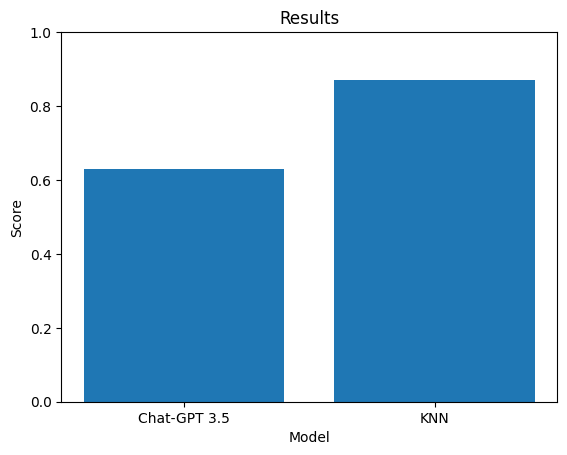

In [179]:
import matplotlib.pyplot as plt


bar_labels = ['Chat-GPT 3.5', 'KNN'] 
scores = [0.63, 0.87]

plt.bar(bar_labels, scores)

plt.ylim(0, 1.0)

plt.title('Results')
plt.ylabel('Score')
plt.xlabel('Model')

plt.show()